In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
%matplotlib inline

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))
train.shape, test.shape, all_data.shape

((1460, 81), (1459, 80), (2919, 79))

1.880940746034036

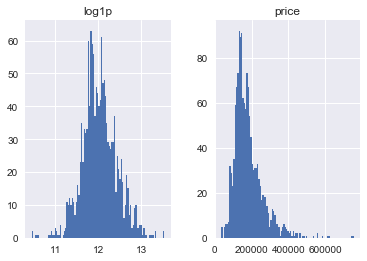

In [2]:
pd.DataFrame({'price': train['SalePrice'], 'log1p': np.log1p(train['SalePrice'])}).hist(bins=100)
skew(train['SalePrice'])

In [3]:
# log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

# log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [4]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
all_data.shape

(2919, 288)

In [5]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))

0.12733723291530383

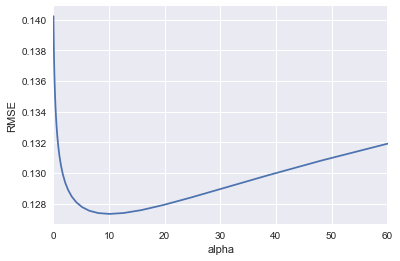

In [6]:
# Ridge (quadratic)
alphas = np.power(1.25, np.arange(0, 40)) / 100
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot().set(xlabel='alpha', ylabel='RMSE')
cv_ridge.min()

0.12260211198950902

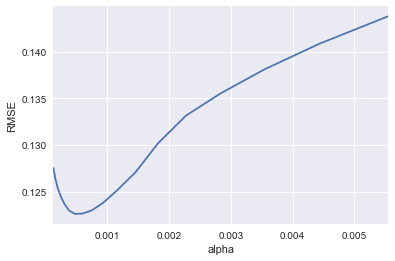

In [7]:
# Lasso (absolute)
alphas = np.power(1.25, np.arange(0, 18)) / 8000
cv_lasso = [rmse_cv(Lasso(alpha=alpha)).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index=alphas)
cv_lasso.plot().set(xlabel='alpha', ylabel='RMSE')
cv_lasso.min()

In [8]:
model_lasso = LassoCV(alphas=[1, .1, .001, .0005]).fit(X_train, y)
print(rmse_cv(model_lasso).mean())
coef = pd.Series(model_lasso.coef_, index=X_train.columns)
print(sum(coef != 0), "picked,", sum(coef == 0), "eliminated")

0.12314421091
110 picked, 178 eliminated


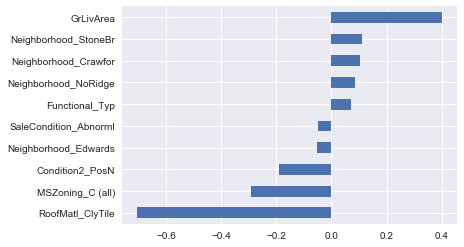

In [9]:
pd.concat([coef.sort_values().head(), coef.sort_values().tail()]).plot("barh")

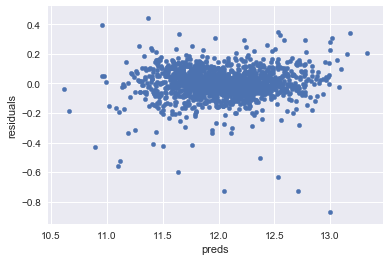

In [10]:
preds = pd.DataFrame({"preds": model_lasso.predict(X_train)})
preds["residuals"] = y - preds.preds
preds.plot("preds", "residuals", "scatter")

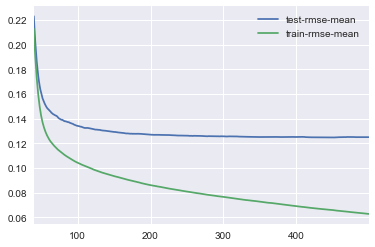

In [12]:
dtrain = xgb.DMatrix(X_train, y)
dtest = xgb.DMatrix(X_test)

modelcv = xgb.cv({"eta": .1, "max_depth": 2}, dtrain, 500)
modelcv.loc[40:, ["test-rmse-mean", "train-rmse-mean"]].plot()

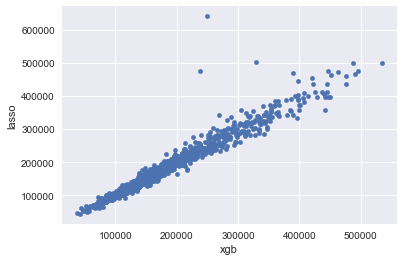

In [13]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=.1).fit(X_train, y)

xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({"xgb": xgb_preds, "lasso": lasso_preds})
predictions.plot("xgb", "lasso", "scatter")

In [14]:
preds = np.exp(np.log(xgb_preds) * .3 + np.log(lasso_preds) * .7)
sub = pd.DataFrame({"Id": test.Id, "SalePrice": preds})
sub.to_csv("sub.csv", index=False)